Task 1: Data Filtering

In [14]:
# Install NLP and Plotting libraries
%pip install spacy nltk wordcloud seaborn matplotlib

# Download the English language model for spaCy
!python -m spacy download en_core_web_sm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 12.8/12.8 MB 88.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

In [16]:
import pandas as pd
import os

# --- CONFIGURATION ---
INPUT_FILE = '../../../data/weighted_score_above_08.csv' 
OUTPUT_FILE = '../../../data/filtered_reviews.csv'

print("--- TASK 1: Data Filtering Started ---")

# --- STEP 1: LOAD DATA ---
# Define columns that we mainly need to use to save memory and time
cols_to_read = [
    'language', 
    'review', 
    'voted_up', 
    'weighted_vote_score', 
    'votes_funny', 
    'steam_purchase', 
    'received_for_free', 
    'written_during_early_access', 
    'author_playtime_at_review', 
    'author_num_games_owned', 
    'author_num_reviews', 
    'game'
]

print(f"Loading {INPUT_FILE}...")

# pd.read_csv loads the specific columns into memory immediately
df = pd.read_csv(
    INPUT_FILE, 
    usecols=cols_to_read,
    dtype={
        'votes_funny': 'float',
        'weighted_vote_score': 'float',
        'author_playtime_at_review': 'float',
        'author_num_games_owned': 'float',
        'author_num_reviews': 'float',
        'voted_up': 'object'
    },
    on_bad_lines='skip' 
)

# --- STEP 2: FILTER FOR ENGLISH ---
if 'language' in df.columns:
    print(f"Initial rows: {len(df)}")
    df = df[df['language'] == 'english']
    print(f"Rows after English filter: {len(df)}")
else:
    raise ValueError("The 'language' column was not found in the dataset")

# --- STEP 3: CLEANUP TEXT ---
print("Cleaning text (removing newlines)...")
# Replace newlines/carriage returns with space
df['review'] = df['review'].str.replace(r'[\n\r]+', ' ', regex=True)
df['review'] = df['review'].str.strip()

# --- STEP 4: SELECT FINAL COLUMNS ---
# Drop language column as it is now redundant
df = df.drop(columns=['language'])

# --- STEP 5: SAVE ---
# Drop rows where review content is missing
df = df.dropna(subset=['review'])

print(f"Saving filtered data to {OUTPUT_FILE}...")
df.to_csv(OUTPUT_FILE, index=False)

print("--- Task 1 Complete :D ---")

--- TASK 1: Data Filtering Started ---
Loading ../../../data/weighted_score_above_08.csv...
Initial rows: 498094
Rows after English filter: 193174
Cleaning text (removing newlines)...
Saving filtered data to ../../../data/filtered_reviews.csv...
--- Task 1 Complete :D ---


In [17]:
# CONFIGURATION
# Establish input and output files
INPUT_FILE = '../../../data/filtered_reviews.csv'
OUTPUT_FILE = '../../../data/processed_text.csv'

# Load the English model for spaCy (lemmatization)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) # Disable parser/ner for speed

# Download NLTK stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Add custom stopwords specific to gaming/Steam if needed
custom_stops = {'game', 'play', 'played', 'hour', 'time', 'steam'} 
stop_words.update(custom_stops)

In [18]:
# 1. Load data and define ML problem
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

# Quick check to ensure no empty reviews slipped through
df = df.dropna(subset=['review'])
print(f"Loaded {len(df)} reviews.")

# Number of rows and columns
print(f"\nShape of Dataset: ", df.shape)
display(f"Dataframe's head: ", df.head())


# Definition
# Supervised Learning - Binary Classification Problem
# Label - Voted Up (True/False), predict whether a review is positive (voted up) or 
# negative (not voted up) based on features and text content

Loading data from ../../../data/filtered_reviews.csv...
Loaded 193166 reviews.

Shape of Dataset:  (193166, 11)


"Dataframe's head: "

,game,author_num_games_owned,author_num_reviews,author_playtime_at_review,review,voted_up,votes_funny,weighted_vote_score,steam_purchase,received_for_free,written_during_early_access
0,Counter-Strike,41.0,10.0,221.0,cs 1.6>cs2,1,13.0,0.863652,1,0,0
1,Counter-Strike,0.0,1.0,396410.0,#1 PLAYED PC GAME ONLINE SINCE 1999,1,1.0,0.865922,1,0,0
2,Counter-Strike,50.0,50.0,81.0,"best played with a membrane keyboard, a roller...",1,31.0,0.935513,1,0,0
3,Counter-Strike,11.0,5.0,78.0,My friend who I play counter-strike with said ...,1,19.0,0.875650,1,0,0
4,Counter-Strike,0.0,27.0,26568.0,Counter-Strike won't ever be canceled. Counter...,1,2.0,0.877432,1,0,0


In [19]:
# 2. Text Preprocessing Function (Lowercase, remove special characters/numbers, tokenize, lemmatize, and remove stopwords 
def preprocess_text(text):
    # Lowercase & basic cleanup via Regex
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Process with spaCy
    doc = nlp(text)
    
    # Lemmatize and filter stopwords/
    cleaned_tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_space]
    
    return " ".join(cleaned_tokens)

In [20]:
print("Starting text preprocessing")

# Apply the function to the 'review' column
df['cleaned_review'] = df['review'].apply(preprocess_text)

print("Preprocessing complete!")
# Save Output
# Save the dataset with the new 'cleaned_review' column
# df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved processed data to {OUTPUT_FILE}")

Starting text preprocessing
Preprocessing complete!
Saved processed data to ../../../data/processed_text.csv


In [21]:
# df = pd.read_csv(OUTPUT_FILE)
df['cleaned_review'] = df['cleaned_review'].fillna('')

Generating Frequency Plot...


C:\Users\anya\AppData\Local\Temp\ipykernel_41400\3365029400.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')


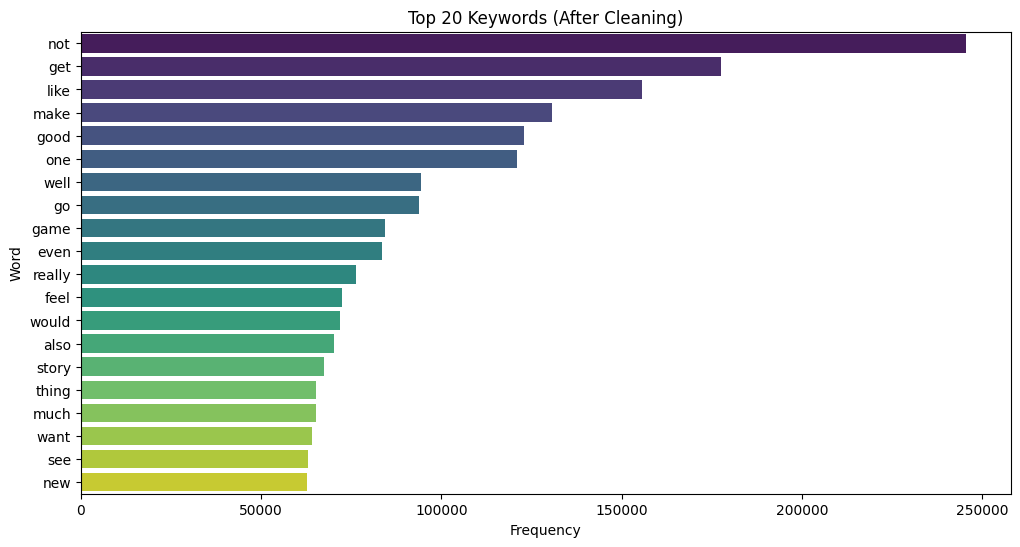

In [22]:
# 4. Keyword Frequency Plot
print("Generating Frequency Plot...")
# Split all cleaned reviews into a giant list of words
all_words = " ".join(df['cleaned_review']).split()
word_freq = Counter(all_words)

# Get top 20 words
common_words = word_freq.most_common(20)
words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 20 Keywords (After Cleaning)')
plt.show()

Generating Correlation Heatmap...


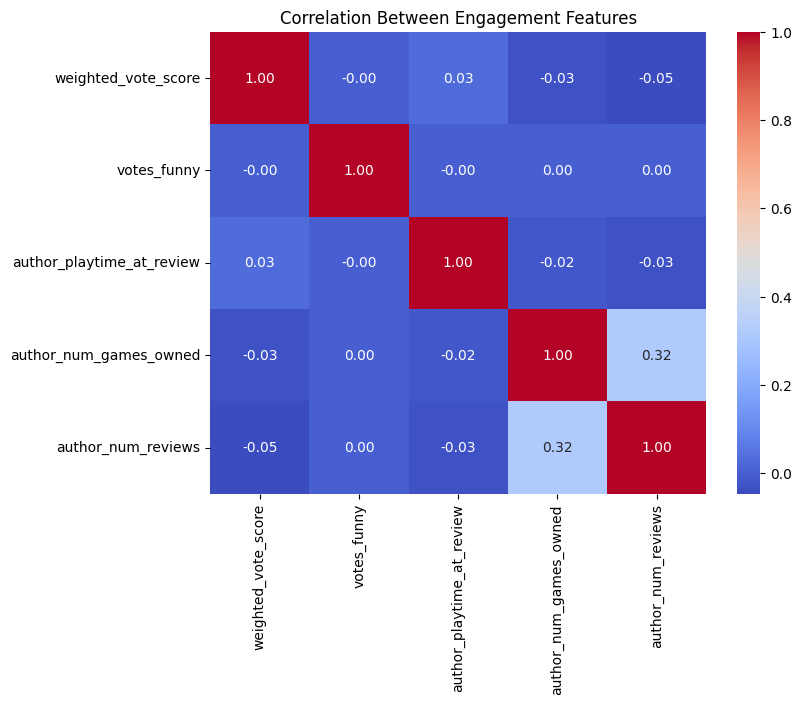

In [40]:
# 5. Correlation Heatmap
print("Generating Correlation Heatmap...")

# Select only numerical columns for correlation
numeric_cols = [
    'weighted_vote_score', 'votes_funny', 'author_playtime_at_review', 
    'author_num_games_owned', 'author_num_reviews'
]

categorical_cols = ['steam_purchase', 'received_for_free', 'written_during_early_access']

# Calculate correlation matrix
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Engagement Features')
plt.show()

,weighted_vote_score,votes_funny,author_playtime_at_review,author_num_games_owned,author_num_reviews
count,193166.000000,1.931660e+05,1.931660e+05,193166.000000,193166.000000
mean,0.858477,4.454213e+04,1.072348e+04,415.369480,49.129842
std,0.042107,1.382001e+07,6.006570e+04,1331.560964,153.630452
min,0.800000,0.000000e+00,0.000000e+00,0.000000,1.000000
25%,0.823212,3.000000e+00,1.180000e+02,0.000000,5.000000
50%,0.850720,1.100000e+01,6.420000e+02,48.000000,14.000000
75%,0.887437,4.900000e+01,2.909000e+03,330.000000,40.000000
max,0.995547,4.294967e+09,4.776595e+06,30425.000000,10413.000000


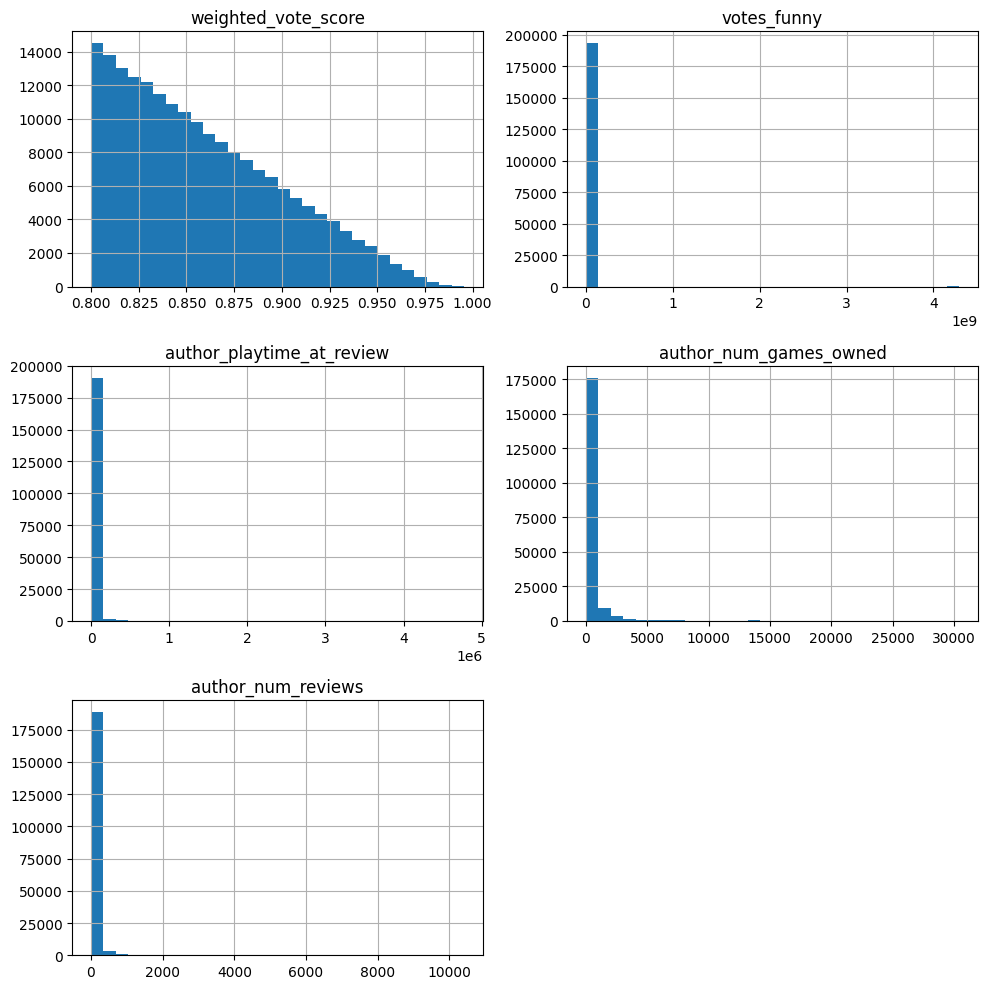

In [41]:
# Exploratory Analysis
display(df[numeric_cols].describe())
df[numeric_cols].hist(bins=30, figsize=(10,10))
plt.tight_layout()
plt.show()

In [42]:
# We can see that the features are all extremely right skewed with clear outliers
# Weighted_vote_score has a nice gradual right skew while every other feature has a clear tail with large outliers
# This shows a need for feature standardization

In [43]:
# 6. Save Output
# Save the dataset with the new 'cleaned_review' column
df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved processed data to {OUTPUT_FILE}")

Saved processed data to ../../../data/processed_text.csv


In [64]:
numeric_features = ['author_playtime_at_review', 'author_num_games_owned', 'author_num_reviews', 'votes_funny', 'weighted_vote_score']
text_feature = 'cleaned_review'
target = 'voted_up'

df[target] = df[target].astype(int)
X = df[numeric_features + [text_feature]]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 2. Create Preprocessor
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
text_transformer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('txt', text_transformer, text_feature)
    ])

Training Logistic Regression...
Logistic Regression Results:
  Training Accuracy: 0.9016
  Test Accuracy:     0.8965
  Test Precision:    0.9119
  Test Recall:       0.9655
  Test F1 Score:     0.9379


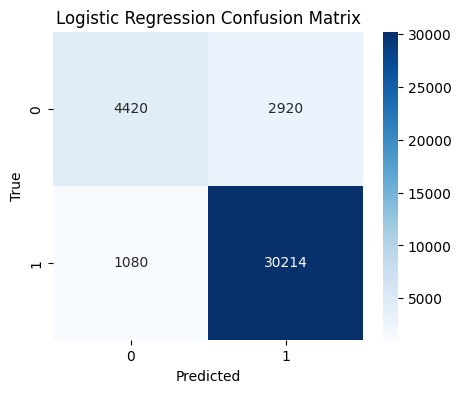

In [66]:
# LOGISTIC REGRESSION
print("Training Logistic Regression...")

# 1. Make Pipeline
log_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000, random_state=0))])

# 2. Train
log_pipe.fit(X_train, y_train)

# 3. Predict
y_train_pred = log_pipe.predict(X_train)
y_test_pred = log_pipe.predict(X_test)

# 4. Results
print("Logistic Regression Results:")
print(f"  Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  Test Accuracy:     {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Test Precision:    {precision_score(y_test, y_test_pred):.4f}")
print(f"  Test Recall:       {recall_score(y_test, y_test_pred):.4f}")
print(f"  Test F1 Score:     {f1_score(y_test, y_test_pred):.4f}")

# 5. Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Training Decision Tree...
Decision Tree Results:
  Training Accuracy: 1.0000
  Test Accuracy:     0.8090
  Test Precision:    0.8797
  Test Recall:       0.8852
  Test F1 Score:     0.8824


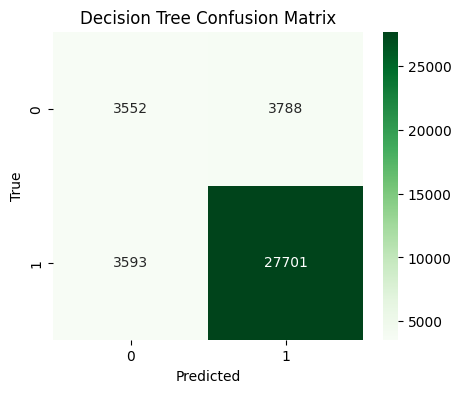

voted_up
1    0.807306
0    0.192694
Name: proportion, dtype: float64
This shows that logistic regression just guessed 'positive' for all of the reviews.


In [ ]:
# DECISION TREE
print("Training Decision Tree...")

# 1. Make Pipeline
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', DecisionTreeClassifier(random_state=0))])

# 2. Train
dt_pipe.fit(X_train, y_train)

# 3. Predict
y_train_pred = dt_pipe.predict(X_train)
y_test_pred = dt_pipe.predict(X_test)

# 4. Results
print("Decision Tree Results:")
print(f"  Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  Test Accuracy:     {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Test Precision:    {precision_score(y_test, y_test_pred):.4f}")
print(f"  Test Recall:       {recall_score(y_test, y_test_pred):.4f}")
print(f"  Test F1 Score:     {f1_score(y_test, y_test_pred):.4f}")

# 5. Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(df['voted_up'].value_counts(normalize=True))
# print("This shows that logistic regression just guessed 'positive' for all of the reviews.")

Training KNN...
KNN Results:
  Training Accuracy: 0.8174
  Test Accuracy:     0.8114
  Test Precision:    0.8145
  Test Recall:       0.9935
  Test F1 Score:     0.8951


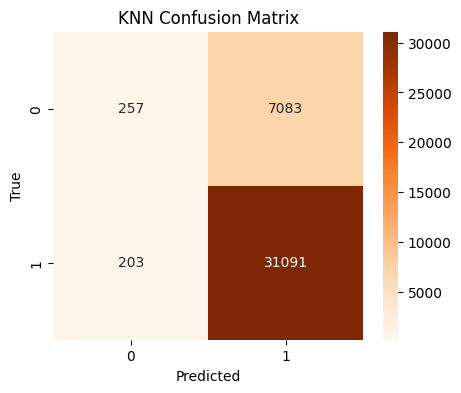

In [68]:
# KNN
print("Training KNN...")

# 1. Make Pipeline
knn_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier(n_neighbors=5))])

# 2. Train
knn_pipe.fit(X_train, y_train)

# 3. Predict
y_train_pred = knn_pipe.predict(X_train)
y_test_pred = knn_pipe.predict(X_test)

# 4. Results
print("KNN Results:")
print(f"  Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"  Test Accuracy:     {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Test Precision:    {precision_score(y_test, y_test_pred):.4f}")
print(f"  Test Recall:       {recall_score(y_test, y_test_pred):.4f}")
print(f"  Test F1 Score:     {f1_score(y_test, y_test_pred):.4f}")

# 5. Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Oranges')
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [71]:
# the more advanced models
for col in ['steam_purchase', 'received_for_free', 'written_during_early_access']:
    if col in df.columns:
        df[col] = df[col].astype(int)

X_adv = df[numeric_cols + categorical_cols +  ['cleaned_review']]
y_adv = df['voted_up'].astype(int)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_adv, y_adv, test_size=0.2, random_state=0)

In [74]:
# numerical transformer
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
# converts text into numerical vectors
text_transformer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
# cat variables
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
preproc = ColumnTransformer(transformers=[('num', numerical_transformer, numeric_cols), ('cat', categorical_transformer, categorical_cols), ('txt', text_transformer, 'cleaned_review')])

In [75]:
# random forest
print("Training Random Forest: ")
randomforest = Pipeline(steps=[('preprocessor', preproc), ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state = 0, n_jobs = 1))])
randomforest.fit(X_train, y_train)
y_pred_train = randomforest.predict(X_train)
y_pred_randomforest = randomforest.predict(X_test)
print("")
print("Random Forest: ")
print(f"Training Accuracy:  {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_randomforest)}")
print(f"Precision: {precision_score(y_test, y_pred_randomforest)}")
print(f"Recall:    {recall_score(y_test, y_pred_randomforest)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_randomforest)}")

# A training accuracy of 1.0 is a clear sign of overfitting

Training Random Forest: 

Random Forest: 
Training Accuracy:  0.9999935288483939
Accuracy:  0.8717709789304757
Precision: 0.8722652495901407
Recall:    0.9860995718029015
F1 Score:  0.925695944324454


In [77]:
# optimizing random forest
X_sub, unused, y_sub, unused2 = train_test_split(X_train, y_train, train_size=10000, stratify=y_train, random_state=0)
rf_pipe = Pipeline(steps=[("preprocessor", preproc), 
                          ("classifier", RandomForestClassifier(class_weight="balanced", random_state=0, n_jobs=1))])
rf_params = {
     "classifier__n_estimators": [100, 200], 
     "classifier__max_depth": [100, 200, 300], 
     "classifier__min_samples_split": [2, 10], 
     "classifier__min_samples_leaf": [1, 5], 
     "classifier__max_features": ["sqrt", 0.5],
}

rf_grid = GridSearchCV(rf_pipe, param_grid=rf_params, scoring="f1", cv=3, n_jobs=-1)
rf_grid.fit(X_sub, y_sub)

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_pred_train = rf_best.predict(X_train)
rf_prob = rf_best.predict_proba(X_test)[:, 1]

print("Random Forest Optimized: ")
print(f"Training Accuracy:  {accuracy_score(y_train, rf_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, rf_pred)}")
print(f"Precision: {precision_score(y_test, rf_pred)}")
print(f"Recall:    {recall_score(y_test, rf_pred)}")
print(f"F1 Score:  {f1_score(y_test, rf_pred)}")

# Accuracy is weaker than default parameters

Random Forest Optimized: 
Training Accuracy:  0.8659889213884503
Accuracy:  0.8589325464616658
Precision: 0.8648427353323169
Recall:    0.9788138301271809
F1 Score:  0.9183055522244874


In [ ]:
# gradient boosting

print("Training Gradient Boosting: ")
gradientboosting = Pipeline(steps=[('preprocessor', preproc), ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=0))])
gradientboosting.fit(X_train, y_train)
y_pred_gradientboosting = gradientboosting.predict(X_test)
y_pred_train = gradientboosting.predict(X_train)
print("")
print("Gradient Boosting: ")
print(f"Training Accuracy:  {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_gradientboosting)}")
print(f"Precision: {precision_score(y_test, y_pred_gradientboosting)}")
print(f"Recall:    {recall_score(y_test, y_pred_gradientboosting)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_gradientboosting)}")

Training Gradient Boosting: 

Gradient Boosting: 
Training Accuracy:  0.8557903864571739
Accuracy:  0.854532277268727
Precision: 0.8550251673212014
Recall:    0.9879210072218316
F1 Score:  0.9166814920239578


In [ ]:
# optimizing gradient boosting

gb_pipe = Pipeline(steps=[("preprocessor", preproc), 
                          ("classifier", GradientBoostingClassifier(random_state=0))])
gb_params = {
     "classifier__n_estimators": [100, 200], 
     "classifier__learning_rate": [.01, .05, .1], 
     "classifier__max_depth": [3, 5], 
     "classifier__subsample": [.8, 1]
}

gb_grid = GridSearchCV(gb_pipe, param_grid=gb_params, scoring="f1", cv=3, n_jobs=-1)
gb_grid.fit(X_sub, y_sub)

gb_best = gb_grid.best_estimator_
gb_pred = gb_best.predict(X_test)
gb_pred_train = gb_best.predict(X_train)
gb_prob = gb_best.predict_proba(X_test)[:, 1]

print("Gradient Boosting optimized: ")
print(f"Training Accuracy:  {accuracy_score(y_train, gb_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, gb_pred)}")
print(f"Precision: {precision_score(y_test, gb_pred)}")
print(f"Recall:    {recall_score(y_test, gb_pred)}")
print(f"F1 Score:  {f1_score(y_test, gb_pred)}")

Gradient Boosting optimized: 
Training Accuracy:  0.8610579038645717
Accuracy:  0.8591655018895273
Precision: 0.8658892128279884
Recall:    0.9775356298331949
F1 Score:  0.9183315071371748


In [86]:
print("Best parameters for Random Forest: ", rf_grid.best_params_)
print("Best parameters for Gradient Boosting: ", gb_grid.best_params_)

Best parameters for Random Forest:  {'classifier__max_depth': 200, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best parameters for Gradient Boosting:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


In [ ]:
# adaboost
adaboost = Pipeline(steps=[('preprocessor', preproc), ('classifier', AdaBoostClassifier(n_estimators=50, random_state=0))])
print("Training AdaBoost: ")
adaboost.fit(X_train, y_train)
y_pred_adaboost = adaboost.predict(X_test)
print("")
print("Ada Boosting: ")
print(f"Training Accuracy:  {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_adaboost)}")
print(f"Precision: {precision_score(y_test, y_pred_adaboost)}")
print(f"Recall:    {recall_score(y_test, y_pred_adaboost)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_adaboost)}")

Training AdaBoost: 

Ada Boosting: 
Training Accuracy:  0.8557903864571739
Accuracy:  0.8211937671481079
Precision: 0.824161216568299
Recall:    0.9906052278392024
F1 Score:  0.8997503918267835


In [ ]:
# support vector machine
svm_model = Pipeline(steps=[('preprocessor', preproc), ('classifier', LinearSVC(C=1.0, random_state=0, dual='auto'))])
print("Training Linear SVM: ")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("")
print("Linear SVM: ")
print(f"Training Accuracy:  {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_svm)}")
print(f"Precision: {precision_score(y_test, y_pred_svm)}")
print(f"Recall:    {recall_score(y_test, y_pred_svm)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_svm)}")

Training Linear SVM: 

Linear SVM: 
Training Accuracy:  0.8557903864571739
Accuracy:  0.8969301651395144
Precision: 0.9161891990735097
Recall:    0.9606314309452291
F1 Score:  0.9378841294106636


In [ ]:
# neural network
nn= Pipeline(steps=[('preprocessor', preproc), ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=0))])
print("Training Neural Network: ")
nn.fit(X_train, y_train)
y_pred_nn = nn.predict(X_test)
print("")
print("Neural Network: ")
print(f"Training Accuracy:  {accuracy_score(y_train, y_pred_train)}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_nn)}")
print(f"Precision: {precision_score(y_test, y_pred_nn)}")
print(f"Recall:    {recall_score(y_test, y_pred_nn)}")
print(f"F1 Score:  {f1_score(y_test, y_pred_nn)}")

Training Neural Network: 


C:\Users\anya\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:788: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")



Neural Network: 
Training Accuracy:  0.8557903864571739
Accuracy:  0.8900709219858156
Precision: 0.9338766081683724
Recall:    0.9301463539336614
F1 Score:  0.9320077485871636


array([[ 2821,  4519],
       [  435, 30859]], dtype=int64)

array([[ 2098,  5242],
       [  378, 30916]], dtype=int64)

array([[  726,  6614],
       [  294, 31000]], dtype=int64)

array([[ 4590,  2750],
       [ 1232, 30062]], dtype=int64)

array([[ 5279,  2061],
       [ 2186, 29108]], dtype=int64)

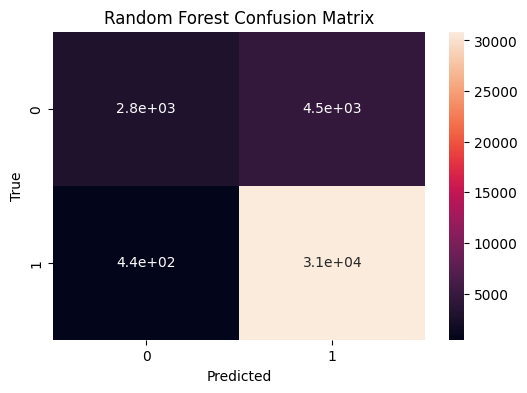

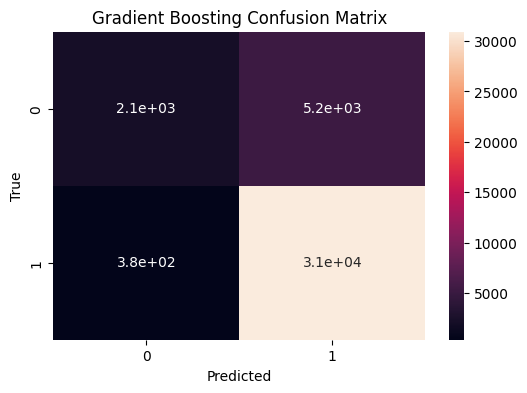

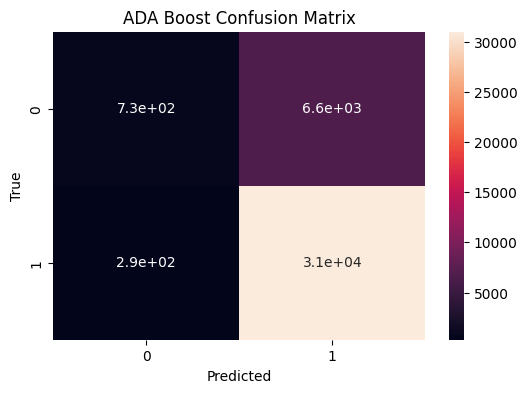

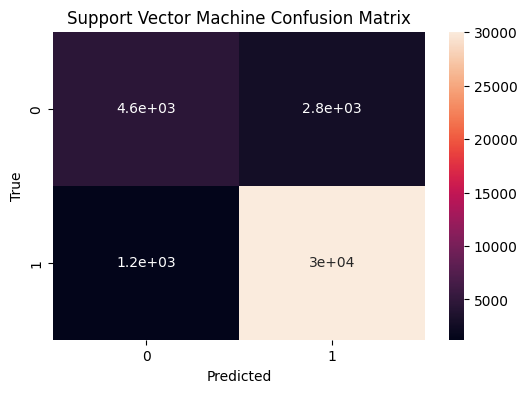

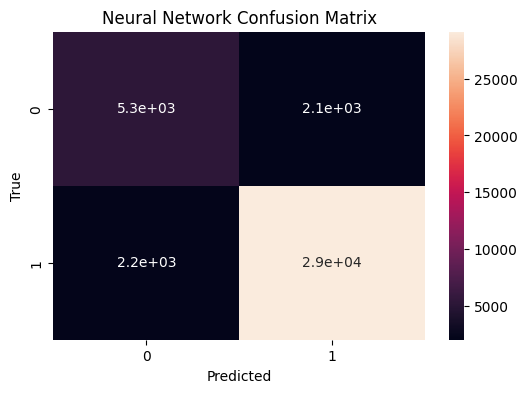

In [ ]:
# Confusion Matrices for the complex models

# Random Forest
display(confusion_matrix(y_test, y_pred_randomforest));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_randomforest), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Random Forest Confusion Matrix');

# Gradient Boosting
display(confusion_matrix(y_test, y_pred_gradientboosting));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_gradientboosting), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Gradient Boosting Confusion Matrix');

# ADA Boost
display(confusion_matrix(y_test, y_pred_adaboost));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_adaboost), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('ADA Boost Confusion Matrix');

# Support Vector Machines
display(confusion_matrix(y_test, y_pred_svm));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Support Vector Machine Confusion Matrix');

# Neural Network
display(confusion_matrix(y_test, y_pred_nn));
plt.figure(figsize = (6, 4));
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True);
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title('Neural Network Confusion Matrix');

In [78]:
# Ada Boost Optimization

ada_pipe = Pipeline(steps=[
    ("preprocessor", preproc),
    ("classifier", AdaBoostClassifier(random_state=0))
])

ada_param = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate":[0.01, 0.1, 1.0]
}

ada_grid = GridSearchCV(
    ada_pipe,
    param_grid=ada_param,
    scoring="f1", 
    cv=3,
    n_jobs=-1
)

ada_grid.fit(X_sub, y_sub)

print("Best AdaBoost Parameters: ", ada_grid.best_params_)

ada_pred = ada_grid.best_estimator_.predict(X_test)
ada_prob = ada_grid.best_estimator_.predict_proba(X_test)[:, 1] # ROC

Best AdaBoost Parameters:  {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 200}


In [79]:
# SVM Optimization

svm_pipe = Pipeline(steps=[
    ("preprocessor", preproc),
    ("classifier", LinearSVC(dual="auto"))
])

svm_param = {
    "classifier__C": [0.01, 0.1, 1, 5]
}

svm_grid = GridSearchCV(
    svm_pipe, 
    param_grid=svm_param, 
    cv=3, 
    scoring="f1", 
    n_jobs=-1
)

svm_grid.fit(X_sub, y_sub)

print("Best SVM Parameters: ", svm_grid.best_params_)

svm_pred = svm_grid.best_estimator_.predict(X_test)
svm_prob = svm_grid.best_estimator_.decision_function(X_test)

Best SVM Parameters:  {'classifier__C': 1}


In [80]:
# Neural Network Optimization

nn_pipe = Pipeline(steps=[
    ("preprocessor", preproc),
    ("classifier", MLPClassifier(max_iter=300, random_state=0))
])

nn_param = {
    "classifier__hidden_layer_sizes": [(50,), (100,), (100, 50)],
    "classifier__alpha": [0.001, 0.01, 0.1],
    "classifier__learning_rate_init": [0.001, 0.01]
}

nn_grid = GridSearchCV(
    nn_pipe, 
    param_grid=nn_param,
    scoring="f1",
    cv=3,
    n_jobs=-1
)

nn_grid.fit(X_sub, y_sub)

print("Best NN Parameters: ", nn_grid.best_params_)

nn_pred = nn_grid.best_estimator_.predict(X_test)
nn_prob = nn_grid.best_estimator_.predict_proba(X_test)[:,1]

Best NN Parameters:  {'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate_init': 0.001}


AdaBoost: 
Precision: 0.8393727369252131
Recall: 0.9852048315971113
F1 Score: 0.9064608599779492

Linear SVM: 
Precision: 0.8981461816195879
Recall: 0.9459321275643894
F1 Score: 0.921420011516972

Neural Network
Precision: 0.898736880644374
Recall: 0.9412986514986899
F1 Score: 0.9195255189636335

Random Forest: 
Precision: 0.8648427353323169
Recall: 0.9788138301271809
F1 Score: 0.9183055522244874

Gradient Boosting
Precision: 0.8658892128279884
Recall: 0.9775356298331949
F1 Score: 0.9183315071371748


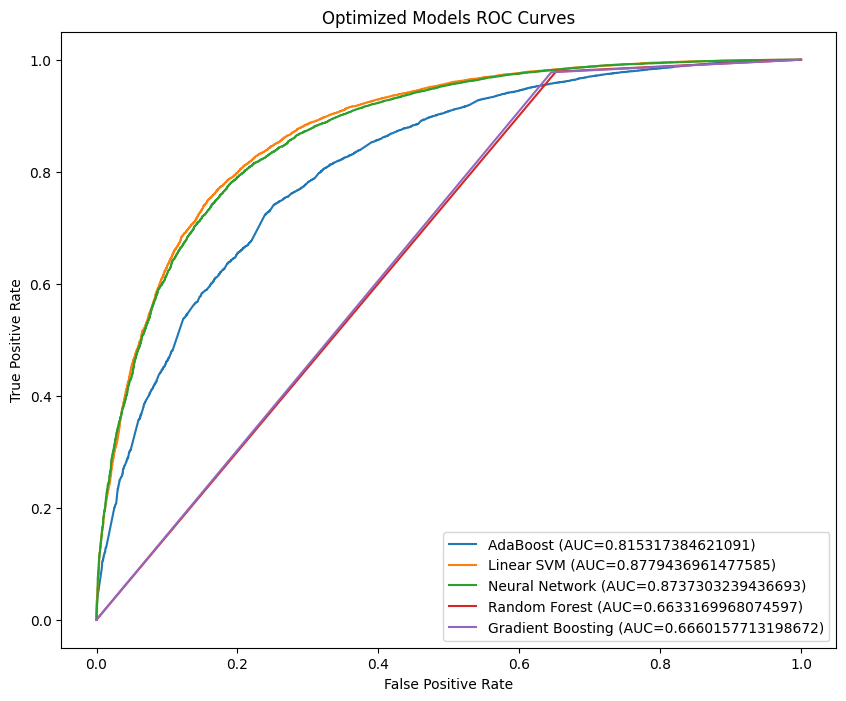


AUC Scores: 
AdaBoost AUC: 0.815317384621091
SVM AUC: 0.8779436961477585
NN AUC: 0.8737303239436693
Random Forest AUC: 0.6633169968074597
Gradient Boosting AUC: 0.6660157713198672


In [81]:
# Precision, Recall, F1

def display_prf(name, y_t, y_pred):
    print(name)
    print(f"Precision: {precision_score(y_t, y_pred)}")
    print(f"Recall: {recall_score(y_t, y_pred)}")
    print(f"F1 Score: {f1_score(y_t, y_pred)}")

display_prf("AdaBoost: ", y_test, ada_pred)
display_prf("\nLinear SVM: ", y_test, svm_pred)
display_prf("\nNeural Network", y_test, nn_pred)
display_prf("\nRandom Forest: ", y_test, rf_pred)
display_prf("\nGradient Boosting", y_test, gb_pred)

# ROC Curves

plt.figure(figsize=(10, 8))

# Adaboost ROC
ada_f, ada_t, _ =  roc_curve(y_test, ada_prob)
ada_auc = roc_auc_score(y_test, ada_prob)
plt.plot(ada_f, ada_t, label=f"AdaBoost (AUC={ada_auc})")

# svm ROC
svm_f, svm_t, _ = roc_curve(y_test, svm_prob)
svm_auc = roc_auc_score(y_test, svm_prob)
plt.plot(svm_f, svm_t, label=f"Linear SVM (AUC={svm_auc})")

# nn ROC
nn_f, nn_t, _ = roc_curve(y_test, nn_prob)
nn_auc = roc_auc_score(y_test, nn_prob)
plt.plot(nn_f, nn_t, label=f"Neural Network (AUC={nn_auc})")

# Random Forest ROC
rf_f, rf_t, _ =  roc_curve(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred)
plt.plot(rf_f, rf_t, label=f"Random Forest (AUC={rf_auc})")

# Gradient Boosting ROC
gb_f, gb_t, _ =  roc_curve(y_test, gb_pred)
gb_auc = roc_auc_score(y_test, gb_pred)
plt.plot(gb_f, gb_t, label=f"Gradient Boosting (AUC={gb_auc})")

plt.title("Optimized Models ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("\nAUC Scores: ")
print(f"AdaBoost AUC: {ada_auc}")
print(f"SVM AUC: {svm_auc}")
print(f"NN AUC: {nn_auc}")
print(f"Random Forest AUC: {rf_auc}")
print(f"Gradient Boosting AUC: {gb_auc}")

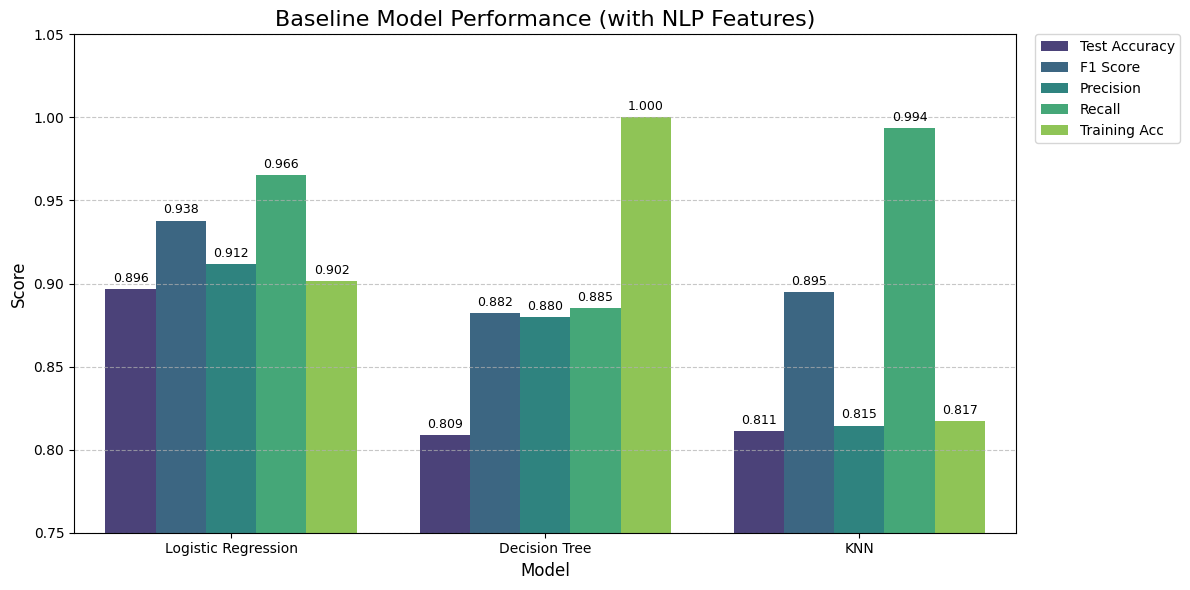

In [82]:
# comaprisons for baseline models
data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'KNN'],
    'Test Accuracy': [0.8965, 0.8090, 0.8114],
    'F1 Score':      [0.9379, 0.8824, 0.8951],
    'Precision':     [0.9119, 0.8797, 0.8145],
    'Recall':        [0.9655, 0.8852, 0.9935],
    'Training Acc':  [0.9016, 1.0000, 0.8174] 
}

# Convert to DataFrame
df_results = pd.DataFrame(data)

# 2. Reshape Data for Plotting
df_melted = df_results.melt(id_vars="Model", var_name="Metric", value_name="Score")

# 3. Create the Graph
plt.figure(figsize=(12, 6))

# Draw the grouped bar chart
plot = sns.barplot(x="Model", y="Score", hue="Metric", data=df_melted, palette="viridis")

# 4. Styling
plt.title("Baseline Model Performance (with NLP Features)", fontsize=16)
plt.ylim(0.75, 1.05)  # Zoom in to show differences clearly
plt.ylabel("Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for container in plot.containers:
    plot.bar_label(container, fmt='%.3f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

Logistic Regression:
Precision: 0.9119
Recall:    0.9655
F1 Score:  0.9379

Decision Tree:
Precision: 0.8797
Recall:    0.8852
F1 Score:  0.8824

K-Nearest Neighbors (KNN):
Precision: 0.8145
Recall:    0.9935
F1 Score:  0.8951


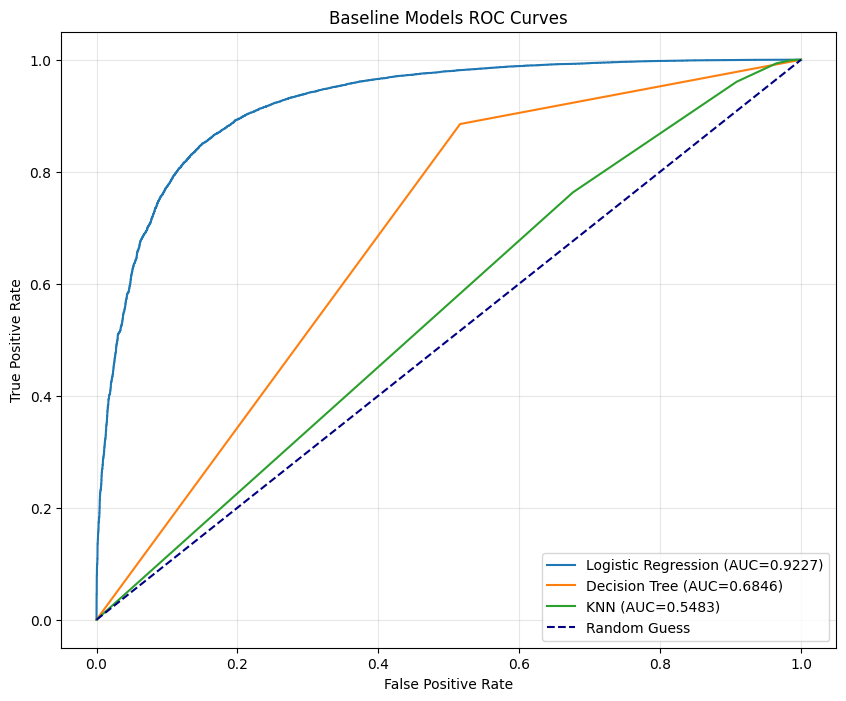


AUC Scores:
Logistic Regression AUC: 0.9227
Decision Tree AUC:       0.6846
KNN AUC:                 0.5483


In [90]:
# Logistic Regression
log_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(max_iter=1000, random_state=0))])
log_pipe.fit(X_train, y_train)
log_pred = log_pipe.predict(X_test)
log_prob = log_pipe.predict_proba(X_test)[:, 1] # Probability of "Positive" class

# Decision Tree
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', DecisionTreeClassifier(random_state=0))])
dt_pipe.fit(X_train, y_train)
dt_pred = dt_pipe.predict(X_test)
dt_prob = dt_pipe.predict_proba(X_test)[:, 1]

# KNN
knn_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier(n_neighbors=5))])
knn_pipe.fit(X_train, y_train)
knn_pred = knn_pipe.predict(X_test)
knn_prob = knn_pipe.predict_proba(X_test)[:, 1]

# --- 2. Define Helper Function ---
def display_prf(name, y_t, y_pred):
    print(name)
    print(f"Precision: {precision_score(y_t, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_t, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_t, y_pred):.4f}")

# --- 3. Display Metrics ---
display_prf("Logistic Regression:", y_test, log_pred)
display_prf("\nDecision Tree:", y_test, dt_pred)
display_prf("\nK-Nearest Neighbors (KNN):", y_test, knn_pred)

# --- 4. Plot ROC Curves ---
plt.figure(figsize=(10, 8))

# Logistic Regression ROC
log_f, log_t, _ = roc_curve(y_test, log_prob)
log_auc = roc_auc_score(y_test, log_prob)
plt.plot(log_f, log_t, label=f"Logistic Regression (AUC={log_auc:.4f})")

# Decision Tree ROC
dt_f, dt_t, _ = roc_curve(y_test, dt_prob)
dt_auc = roc_auc_score(y_test, dt_prob)
plt.plot(dt_f, dt_t, label=f"Decision Tree (AUC={dt_auc:.4f})")

# KNN ROC
knn_f, knn_t, _ = roc_curve(y_test, knn_prob)
knn_auc = roc_auc_score(y_test, knn_prob)
plt.plot(knn_f, knn_t, label=f"KNN (AUC={knn_auc:.4f})")

# Plot Random Guess Line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess')

# Formatting
plt.title("Baseline Models ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# --- 5. Print AUC Scores ---
print("\nAUC Scores:")
print(f"Logistic Regression AUC: {log_auc:.4f}")
print(f"Decision Tree AUC:       {dt_auc:.4f}")
print(f"KNN AUC:                 {knn_auc:.4f}")

In [85]:
# table of all models summary
data = [
    {"Model": "Linear SVM",          "Configuration": "Default",        "Accuracy": 0.8969, "F1 Score": 0.9379, "Precision": 0.9162, "Recall": 0.9606},
    {"Model": "Logistic Regression", "Configuration": "Baseline (NLP)", "Accuracy": 0.8965, "F1 Score": 0.9379, "Precision": 0.9119, "Recall": 0.9655},
    {"Model": "Neural Network (MLP)","Configuration": "Default",        "Accuracy": 0.8901, "F1 Score": 0.9320, "Precision": 0.9339, "Recall": 0.9301},
    {"Model": "Random Forest",       "Configuration": "Default",        "Accuracy": 0.8718, "F1 Score": 0.9257, "Precision": 0.8723, "Recall": 0.9861},
    {"Model": "Random Forest",       "Configuration": "Optimized",      "Accuracy": 0.8660, "F1 Score": 0.9183, "Precision": 0.8648, "Recall": 0.9788},
    {"Model": "Gradient Boosting",   "Configuration": "Optimized",      "Accuracy": 0.8592, "F1 Score": 0.9183, "Precision": 0.8659, "Recall": 0.9775},
    {"Model": "Gradient Boosting",   "Configuration": "Default",        "Accuracy": 0.8545, "F1 Score": 0.9167, "Precision": 0.8550, "Recall": 0.9879},
    {"Model": "AdaBoost",            "Configuration": "Default",        "Accuracy": 0.8212, "F1 Score": 0.8998, "Precision": 0.8242, "Recall": 0.9906},
    {"Model": "KNN",                 "Configuration": "Baseline (NLP)", "Accuracy": 0.8114, "F1 Score": 0.8951, "Precision": 0.8145, "Recall": 0.9935},
    {"Model": "Decision Tree",       "Configuration": "Baseline (NLP)", "Accuracy": 0.8090, "F1 Score": 0.8824, "Precision": 0.8797, "Recall": 0.8852},
]

# 2. Create the DataFrame
df_summary = pd.DataFrame(data)

# 3. Display with styling (Highlighting the best scores)
# This makes it look professional for screenshots/slides
def highlight_best(s):
    is_max = s == s.max()
    return ['background-color: #d1ffd6; color: black; font-weight: bold' if v else '' for v in is_max]

styled_table = df_summary.style.apply(highlight_best, subset=['Accuracy', 'F1 Score', 'Precision', 'Recall']) \
                         .format("{:.4f}", subset=['Accuracy', 'F1 Score', 'Precision', 'Recall']) \
                         .set_caption("Comprehensive Model Performance Leaderboard")

display(styled_table)


,Model,Configuration,Accuracy,F1 Score,Precision,Recall
0,Linear SVM,Default,0.8969,0.9379,0.9162,0.9606
1,Logistic Regression,Baseline (NLP),0.8965,0.9379,0.9119,0.9655
2,Neural Network (MLP),Default,0.8901,0.9320,0.9339,0.9301
3,Random Forest,Default,0.8718,0.9257,0.8723,0.9861
4,Random Forest,Optimized,0.8660,0.9183,0.8648,0.9788
5,Gradient Boosting,Optimized,0.8592,0.9183,0.8659,0.9775
6,Gradient Boosting,Default,0.8545,0.9167,0.8550,0.9879
7,AdaBoost,Default,0.8212,0.8998,0.8242,0.9906
8,KNN,Baseline (NLP),0.8114,0.8951,0.8145,0.9935
9,Decision Tree,Baseline (NLP),0.8090,0.8824,0.8797,0.8852
